# Training LSTM model on Bangla books

First we import necessary packages for our project

In [2]:
import json
from matplotlib import pyplot as plt
import numpy as np
import os
from pathlib import Path
import pickle
import random
import seaborn as sns
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tqdm import tqdm

Set `seaborn` for better data visualization

In [3]:
sns.set()

## Preparing Dataset

Initialize the project root, data, and model related directories. `processed_data` directory contains selected books from renowned authors only.

In [4]:
# get data and model directories
project_root = Path('__file__').resolve().parents[1]

data_dir = project_root / 'processed_data/'
model_home = project_root / 'models/bn_lstm'
plot_dir = model_home / 'plots'

os.makedirs(model_home, exist_ok=True)
os.makedirs(plot_dir, exist_ok=True)

Get list of files in the data directory

In [4]:
filenames = [str(file) for file in Path(data_dir).glob('**/*.txt')]

Then we randomly shuffle the filenames list and select 100 files.

In [5]:
random.shuffle(filenames)
filenames = filenames[:100]

Save filenames to resume training on these later

In [18]:
with open(model_home / 'filenames.pickle', 'wb') as file:
    pickle.dump(filenames, file=file)

Load filenames from pickle file

In [19]:
with open(model_home / 'filenames.pickle', 'rb') as file:
    filenames = pickle.load(file)

Split the files for training and testing. We are keeping 20% for testing and 80% for training.

In [6]:
test_split = 0.2
test_size = int(len(filenames) * test_split)
train_filenames = filenames[:-test_size]
test_filenames = filenames[-test_size:]

Now we create a function that creates a tokenizer with `max_words`, fit it on training files and save to `model_dir`.

In [7]:
def create_tokenizer(files, max_words):
    tokenizer = Tokenizer(num_words=max_words, oov_token="<oov>")
    for file in tqdm(files):
        with open(file, 'r') as f:
            lines = f.read().replace('\n', ' ') # replace new lines with space
            tokenizer.fit_on_texts([lines])

    # save the tokenizer in model dir
    with open(model_home / f'tokenizer_{max_words}_words.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    # save word_index as json file
    with open(model_home / 'word_index.json', 'w') as handle:
        json.dump(tokenizer.word_index, handle, ensure_ascii=False) # write unicode characters

    return tokenizer

Define max words and max sequence length

In [8]:
max_words = 10000
max_seq_len = 200
embed_dim = 256

Now create the tokenizer and fit on training files

In [9]:
tokenizer = create_tokenizer(train_filenames, max_words)

100%|███████████████████████████████████████████| 80/80 [00:12<00:00,  6.33it/s]


`create_dataset` creates a dataset from given `files` and returns two variables - `predictors` which is a sequence of previous words of length `max_sequence_length - 1` and `labels` which is an integer between 0 to `max_words + 1`.
Note that, converting to categorical variables leads to `MemoryError` since it tries to create a sequence of `number of elements in training or test set * (MAX_WORDS + 1)` shape. We are following [this blog](https://medium.com/deep-learning-with-keras/which-activation-loss-functions-in-multi-class-clasification-4cd599e4e61f) and keeping the label as an integer.

In [10]:
def create_dataset(tokenizer, files, max_sequence_length):
    input_sequences = []

    for file in tqdm(files):
        with open(file, 'r') as f:
            lines = f.read().replace('\n', ' ') # replace all new lines with spaces
            token_list = tokenizer.texts_to_sequences([lines])

            for tokens in token_list:
                for i in range(1, len(tokens)):
                    # keep only sequences of length <= max_sequence_length
                    n_gram_sequence = tokens[max(0, i+1-max_sequence_length):i+1]
                    input_sequences.append(n_gram_sequence)

    # pad sequences with 0s so that all sequences have same length
    input_sequences = tf.keras.preprocessing.sequence.pad_sequences(
        input_sequences, maxlen=max_sequence_length, padding='pre')

    predictors, label = input_sequences[:, :-1], input_sequences[:, -1]
    del input_sequences
    return predictors, label

Now we create training dataset `X_train` and `y_train` from training files and test dataset `X_test` and `y_test` from test files.

In [11]:
X_train, y_train = create_dataset(tokenizer, train_filenames, max_seq_len)
X_test, y_test = create_dataset(tokenizer, test_filenames, max_seq_len)

100%|███████████████████████████████████████████| 20/20 [00:05<00:00,  3.81it/s]


## Creating and Training LSTM Models

### Implement an embedding layer

Create two seperate embedding layers: one for tokens and one for token index (positions)

In [12]:
class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    """
    A custom token and position embedding layer
    """
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

`create_model()` returns a model with `no_of_lstm_layers` LSTM layers each with `no_of_units` units and `dropout_rate` dropout. We are compiling the model with loss `sparse_categorical_crossentropy`, optimizer `adam` and metric `sparse_categorical_accuracy`. We are using sparse categorical crossentropy since the values are integers, not one-hot encoded, see this question on [stackexchange](https://stats.stackexchange.com/questions/326065/cross-entropy-vs-sparse-cross-entropy-when-to-use-one-over-the-other) for details.

In [13]:
def create_model(no_of_lstm_layers, no_of_units, dropout_rate):
    """
    Creates model with no of lstm layers, no of units and dropout rate in each layer
    """
    inputs = tf.keras.layers.Input(shape=(max_seq_len - 1,), dtype=tf.int32)
    embedding_layer = TokenAndPositionEmbedding(max_seq_len, max_words + 1, embed_dim)
    x = embedding_layer(inputs)

    # LSTM layers
    for i in range(no_of_lstm_layers - 1):
        x = tf.keras.layers.LSTM(no_of_units, return_sequences=True, dropout=dropout_rate)(x)
    x = tf.keras.layers.LSTM(no_of_units, dropout=dropout_rate)(x)

    outputs = tf.keras.layers.Dense(max_words + 1, activation='softmax')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['sparse_categorical_accuracy'])
    return model

We also need to create a plot to visualize training vs validation accuracy and loss. `create_plot()` creates a plot from history object with a title

In [14]:
def create_plot(history, title):
    """
    Creates plot from history, history object must have
    sparse_categorical_accuracy and loss for both training and validation dataset
    """
    fig = plt.figure(figsize=(10, 6))
    plt.plot(history.history['sparse_categorical_accuracy'], label='sparse_categorical_accuracy')
    plt.plot(history.history['val_sparse_categorical_accuracy'], label='val_sparse_categorical_accuracy')
    plt.title(title + ' Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Sparse Categorical Accuracy')
    plt.legend(loc='lower right')
    plt.show()
    fig.savefig(str(plot_dir / f'{title}_sparse_categorical_accuracy.png'), dpi=fig.dpi)

    fig = plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(title + ' Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='lower right')
    plt.show()
    fig.savefig(str(plot_dir / f'{title}_sparse_categorical_loss.png'), dpi=fig.dpi)

We set callback `EarlyStopping` that monitors `val_loss` for 5 epochs and stops training if it does not improve. It prevents the model from overfitting.

In [15]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                             min_delta=0,
                                             patience=5,
                                             mode='auto')

`get_best_model()` takes a list of parameter and finds the best model parameter that has the best test set accuracy. Each parameter need to be defined as a tuple of three values - no of LSTM layers, no of units in each layer and dropout rate. It also saves the models in a directory `models/model_lstm/model-<no of layers>-<no of units>/model`, plots are saved in `models/model_lstm/plots/`.

In [23]:
def get_best_model(params):
    """Returns the trained model with the best model parameter"""
    best_model = None
    best_model_accuracy = 0.0
    best_model_param = None
    
    for param in params:
        assert len(param) == 3 # must have three items
        model_title = f"model-{param[0]}-{param[1]}"
        plot_title = f"Model with {param[0]} {param[1]} units LSTM layers"
        print(f"Training {plot_title}")
        
        model = create_model(param[0], param[1], param[2])
        # create model and its checkpoint directory
        model_dir = model_home / model_title
        
        # train and save the model
        history = model.fit(X_train, y_train,
                            validation_split=0.2,
                            epochs=20,
                            batch_size=1024,
                            callbacks=[earlystopping])
        model.save(model_dir)
        
        # create, show and save a plot from history
        create_plot(history, plot_title)
        accuracy = model.evaluate(X_test, y_test)[1]
        print(f"Model accuracy: {accuracy}")
        
        if accuracy > best_model_accuracy:
            best_model = model
            best_model_accuracy = accuracy
            best_model_param = param
        
        # save memory by deleting model and history
        del model
        del history
    return best_model, best_model_param

We create three model parameters and use `get_best_model()` function to find the best model.

Training Model with 2 150 units LSTM layers


2022-04-12 08:18:42.882269: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1912777652 exceeds 10% of free system memory.


Epoch 1/20
2347/2347 [==============================] - 714s 303ms/step - loss: 6.6839 - sparse_categorical_accuracy: 0.1823 - val_loss: 6.7334 - val_sparse_categorical_accuracy: 0.1827
Epoch 2/20
2347/2347 [==============================] - 713s 304ms/step - loss: 6.0298 - sparse_categorical_accuracy: 0.1907 - val_loss: 6.4568 - val_sparse_categorical_accuracy: 0.1881
Epoch 3/20
2347/2347 [==============================] - 714s 304ms/step - loss: 5.6522 - sparse_categorical_accuracy: 0.1991 - val_loss: 6.3256 - val_sparse_categorical_accuracy: 0.1914
Epoch 4/20
2347/2347 [==============================] - 714s 304ms/step - loss: 5.4367 - sparse_categorical_accuracy: 0.2055 - val_loss: 6.2751 - val_sparse_categorical_accuracy: 0.1939
Epoch 5/20
2347/2347 [==============================] - 716s 305ms/step - loss: 5.2891 - sparse_categorical_accuracy: 0.2102 - val_loss: 6.2488 - val_sparse_categorical_accuracy: 0.1953
Epoch 6/20
2347/2347 [==============================] - 714s 304ms/ste

2022-04-12 10:18:14.317421: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/model-2-150/assets


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/model-2-150/assets


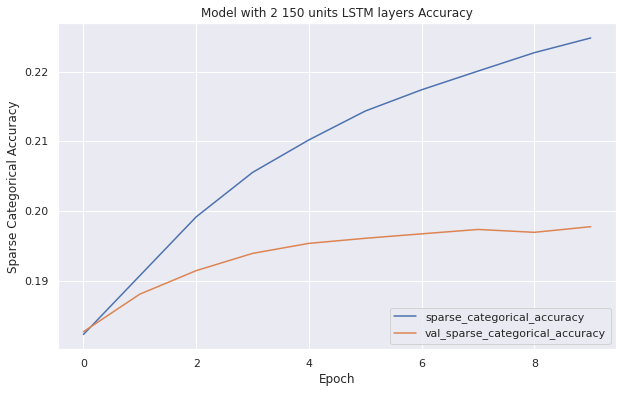

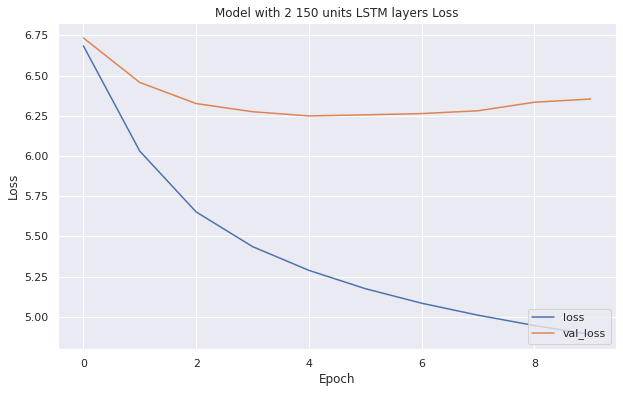

    9/33666 [..............................] - ETA: 7:07 - loss: 2.3019 - sparse_categorical_accuracy: 0.5556

2022-04-12 10:18:18.529261: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 857529208 exceeds 10% of free system memory.


33666/33666 [==============================] - 340s 10ms/step - loss: 5.4619 - sparse_categorical_accuracy: 0.2200
Model accuracy: 0.22003011405467987
Training Model with 3 150 units LSTM layers
Epoch 1/20


2022-04-12 10:24:00.050940: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1912777652 exceeds 10% of free system memory.


2347/2347 [==============================] - 994s 422ms/step - loss: 6.7474 - sparse_categorical_accuracy: 0.1813 - val_loss: 6.8071 - val_sparse_categorical_accuracy: 0.1819
Epoch 2/20
2347/2347 [==============================] - 995s 424ms/step - loss: 6.1239 - sparse_categorical_accuracy: 0.1886 - val_loss: 6.5256 - val_sparse_categorical_accuracy: 0.1864
Epoch 3/20
2347/2347 [==============================] - 994s 424ms/step - loss: 5.7800 - sparse_categorical_accuracy: 0.1951 - val_loss: 6.3998 - val_sparse_categorical_accuracy: 0.1897
Epoch 4/20
2347/2347 [==============================] - 995s 424ms/step - loss: 5.5644 - sparse_categorical_accuracy: 0.2006 - val_loss: 6.3285 - val_sparse_categorical_accuracy: 0.1918
Epoch 5/20
2347/2347 [==============================] - 995s 424ms/step - loss: 5.4155 - sparse_categorical_accuracy: 0.2048 - val_loss: 6.3081 - val_sparse_categorical_accuracy: 0.1937
Epoch 6/20
2347/2347 [==============================] - 994s 424ms/step - loss: 5

INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/model-3-150/assets


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/model-3-150/assets


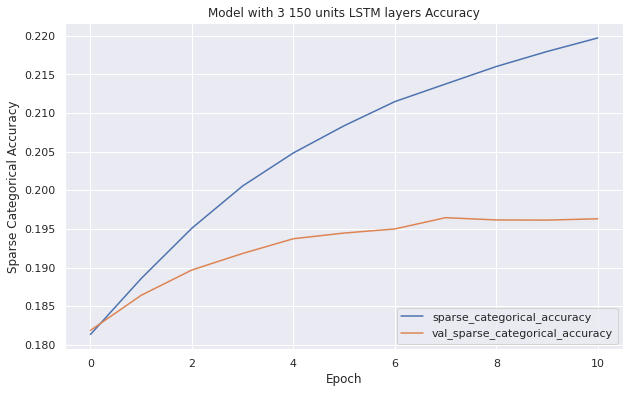

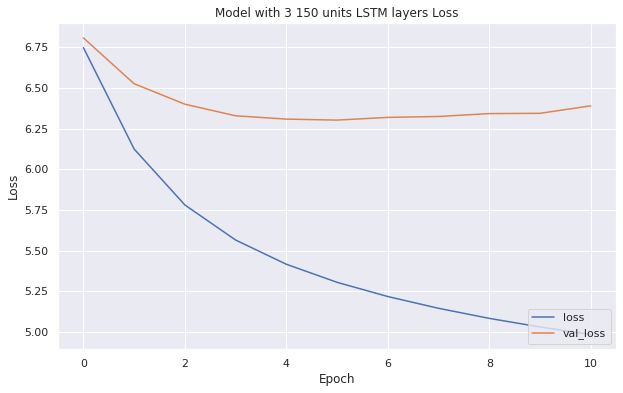

    7/33666 [..............................] - ETA: 10:50 - loss: 2.2654 - sparse_categorical_accuracy: 0.6027

2022-04-12 13:26:27.464514: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 857529208 exceeds 10% of free system memory.


33666/33666 [==============================] - 465s 14ms/step - loss: 5.5075 - sparse_categorical_accuracy: 0.2178
Model accuracy: 0.21779581904411316
Training Model with 2 64 units LSTM layers
Epoch 1/20
2347/2347 [==============================] - 375s 159ms/step - loss: 6.7857 - sparse_categorical_accuracy: 0.1814 - val_loss: 6.8610 - val_sparse_categorical_accuracy: 0.1824
Epoch 2/20
2347/2347 [==============================] - 373s 159ms/step - loss: 6.2755 - sparse_categorical_accuracy: 0.1875 - val_loss: 6.5958 - val_sparse_categorical_accuracy: 0.1868
Epoch 3/20
2347/2347 [==============================] - 373s 159ms/step - loss: 5.9527 - sparse_categorical_accuracy: 0.1931 - val_loss: 6.4552 - val_sparse_categorical_accuracy: 0.1889
Epoch 4/20
2347/2347 [==============================] - 373s 159ms/step - loss: 5.7623 - sparse_categorical_accuracy: 0.1978 - val_loss: 6.3996 - val_sparse_categorical_accuracy: 0.1908
Epoch 5/20
2347/2347 [==============================] - 373s 1

INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/model-2-64/assets


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/model-2-64/assets


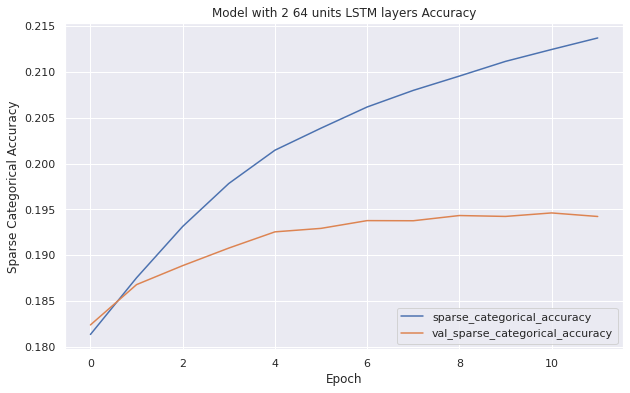

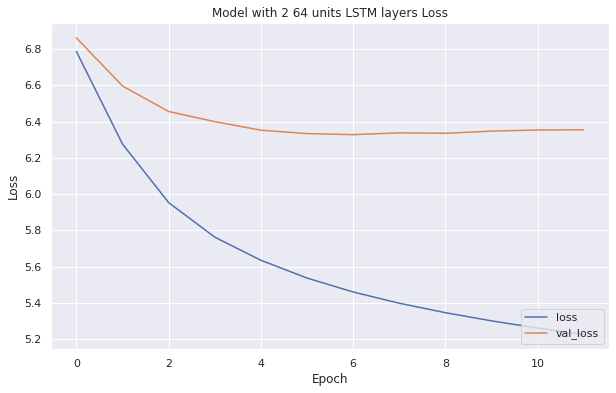

33666/33666 [==============================] - 305s 9ms/step - loss: 5.5803 - sparse_categorical_accuracy: 0.2155
Model accuracy: 0.21550489962100983


In [24]:
params = [(2, 150, 0.2), (3, 150, 0.2), (2, 64, 0.2)]
model, param = get_best_model(params)

Get best model parameters

In [26]:
print(param)

(2, 150, 0.2)


## Testing the model with actual data

Load model and tokenizer from directory

In [9]:
model = tf.keras.models.load_model(model_home / 'model-2-150')

with open(model_home / 'tokenizer_10000_words.pickle', 'rb') as f:
    tokenizer = pickle.load(f)

`predict_next_words` function takes model, tokenizer and text as function argument and returns top 5 next words predicted by the model

In [10]:
def predict_next_words(model, tokenizer, text):
    # tokenize the text
    tokenized_sequence = tokenizer.texts_to_sequences([text])
    # pre-pad with 0's to make it of size MAX_SEQUENCE_LENGTH - 1
    input_sequences = tf.keras.preprocessing.sequence.pad_sequences(tokenized_sequence,
                                                                maxlen=max_seq_len - 1,
                                                                padding='pre')
    # predict using model
    predictions = model.predict(input_sequences)
    ids = np.argsort(predictions, axis=1)[:, -5:] # indices of the top 5 predictions
    # print next word with score
    for id in ids[0]:
        print(tokenizer.index_word[id], "->", predictions[:, id].squeeze())

Test for custom texts by calling the function

In [11]:
text = input("Enter text: ")
predict_next_words(model, tokenizer, text)

Enter text: কেন


NameError: name 'max_seq_len' is not defined

## Converting model to tensorflow lite format

Set converter parameters to convert the model with FP16 quantization

In [33]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter.target_spec.supported_types = [tf.float16]
converter.optimizations = [tf.lite.Optimize.DEFAULT]

Now convert the model and save as `.tflite` file

In [34]:
tflite_model = converter.convert()
# Save the model.
with open(model_home / 'bn_lstm_model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp7lgpfruj/assets


INFO:tensorflow:Assets written to: /tmp/tmp7lgpfruj/assets
2022-04-12 18:03:53.313617: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-04-12 18:03:53.313657: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-04-12 18:03:53.319577: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmp7lgpfruj
2022-04-12 18:03:53.335338: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-04-12 18:03:53.335363: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /tmp/tmp7lgpfruj
2022-04-12 18:03:53.397733: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-04-12 18:03:53.562165: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/tmp7lgpfruj
2022-04-12 18:03:53.669477: I tensorflow/cc/saved_model/loader.cc:301] SavedModel

This model can be used with android applications